# Analyse results from Pypsa-Earth
This notebook reads the latest optimization described in the config.yaml file and makes plots and summaries of the results.

Sources: 
- Plot capacity - map view: https://github.com/pypsa-meets-earth/documentation/blob/main/notebooks/viz/regional_transm_system_viz.ipynb
- Analyse energy potential: https://github.com/pypsa-meets-earth/documentation/blob/main/notebooks/build_renewable_profiles.ipynb
- Analyse energy generation: https://pypsa.readthedocs.io/en/latest/examples/statistics.html

Some files are needed:
* PyPSA network file (e.g. "elec.nc" contains a lot of details and looks perfect)
* a country shape file (may be found in "resources/shapes/country_shapes.geojson")
* a renewable profile file (may be found in "resources/renewable_profiles/....nc)

## Import packages

In [49]:
import yaml
import pypsa
import warnings
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
from datetime import datetime
from cartopy import crs as ccrs
from pypsa.plot import add_legend_circles, add_legend_lines, add_legend_patches
import os
import xarray as xr
import cartopy
import glob
import logging

## Settings

### Set project root

In [50]:
if not os.path.isdir("pypsa-earth"):
    os.chdir("../..")

PARENT = os.path.realpath("pypsa-earth") + os.sep

### Load configuration

In [51]:
with open(os.path.join(PARENT, "config.yaml"), "r") as f:
    cfg = yaml.safe_load(f)

run = cfg.get("run", {}) or {}
scen = cfg.get("scenario", {}) or {}
costs = cfg.get("costs", {}) or {}
expo = cfg.get("export", {}) or {}

results_dir = (cfg.get("results_dir", "results/") or "results/").strip("/") + "/"

### Set add-on file paths

In [52]:
scenario_name = cfg["run"]["name"]
scenario_subpath = scenario_name + "/" if scenario_name else ""

# Network file
network_path = PARENT + f"networks/{scenario_subpath}elec.nc"
# Country shape file
regions_onshore_path = PARENT + f"resources/{scenario_subpath}shapes/country_shapes.geojson"
# Renewable profile file
solar_path = PARENT + f"resources/{scenario_subpath}renewable_profiles/profile_solar.nc"
onwind_path = PARENT + f"resources/{scenario_subpath}renewable_profiles/profile_onwind.nc"

### Directory definitions

In [53]:
RDIR = (run.get("name") or "").strip()
RDIR = (RDIR + "/") if RDIR else ""

elec_dir = os.path.join(PARENT, results_dir, RDIR, "networks")

### Wildcard helper

In [54]:
def pick(val, allow_empty=False):
    """
    Return single value if exactly one is given.
    Return '*' if multiple values or empty (unless allow_empty=True).
    """
    if val is None:
        return "*"
    if isinstance(val, (list, tuple)):
        if len(val) == 1:
            s = "" if val[0] is None else str(val[0])
            return s if (allow_empty or s != "") else "*"
        return "*"
    s = "" if val is None else str(val)
    return s if (allow_empty or s != "") else "*"

### Build wildcard segments

In [55]:
simpl = pick(scen.get("simpl", [""]), allow_empty=True)
clusters = pick(scen.get("clusters"))
ll = pick(scen.get("ll"))
opts = pick(scen.get("opts"))
sopts = pick(scen.get("sopts", [""]), allow_empty=True)
plan = pick(scen.get("planning_horizons"))
dr = pick(costs.get("discountrate"))
demand = pick(scen.get("demand"))

h2_raw = pick(expo.get("h2export"))
h2 = (h2_raw + "export") if h2_raw != "*" else "*export"

### Pattern builders

In [56]:
patterns = [
    os.path.join(elec_dir, f"elec_s{simpl}_{clusters}_ec_l{ll}_{opts}.nc"),
    os.path.join(elec_dir, f"elec_s{simpl}_{clusters}_ec_l{ll}_{opts}_*.nc"),
]

### Find networks

In [57]:
all_matches = []
for pat in patterns:
    all_matches.extend(glob.glob(pat))

# remove duplicates
all_matches = sorted(set(all_matches), key=os.path.getmtime)

if not all_matches:
    recent = sorted(
        glob.glob(os.path.join(PARENT, results_dir, "**", "*.nc"), recursive=True),
        key=os.path.getmtime
    )[-20:]
    recent_txt = "\n".join(os.path.relpath(p, PARENT) for p in recent) or "(none)"
    raise FileNotFoundError(
        "No network matched.\n"
        "Here are the last few .nc files under results/:\n"
        f"{recent_txt}"
    )

print("Found networks:")
for m in all_matches:
    print("-", os.path.relpath(m, PARENT))

Found networks:
- results/networks/elec_s10_10_ec_lcopt_Co2L_3H.nc


## Energy system analysis setup - power and energy generation

In [58]:
warnings.simplefilter(action='ignore', category=FutureWarning)
logging.getLogger("pypsa.io").setLevel(logging.ERROR) # ignore warnings

chosen = all_matches[-1]  # choose newest one
n = pypsa.Network(chosen)
regions_onshore = gpd.read_file(regions_onshore_path)
country_coordinates = regions_onshore.total_bounds[[0, 2, 1, 3]]
warnings.simplefilter(action='default', category=FutureWarning)

## Data import check

Plot of the region of interest

Text(0.5, 1.0, 'NA')

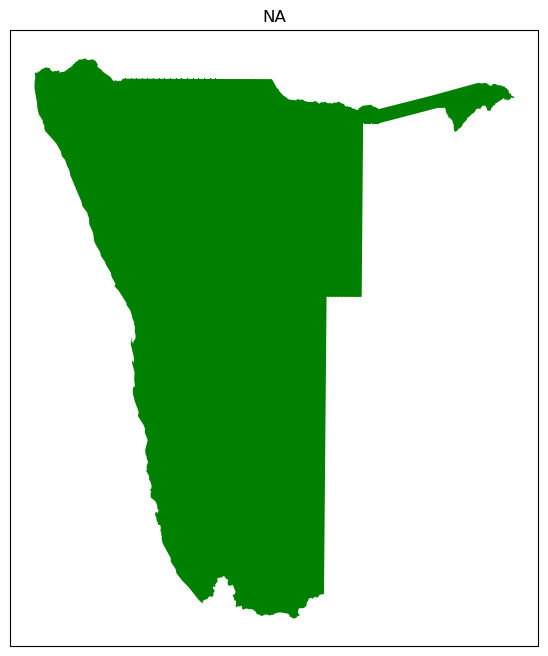

In [59]:
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={"projection": ccrs.EqualEarth(n.buses.x.mean())})
with plt.rc_context({"patch.linewidth": 0.}):
    regions_onshore.plot(
    ax=ax,
    facecolor="green",
    edgecolor="white",
    aspect="equal",
    transform=ccrs.PlateCarree(),
    linewidth=0,
    )
ax.set_title(", ".join(regions_onshore.name.values))

List number of components by type

In [60]:
for c in n.iterate_components(list(n.components.keys())[2:]):
    print("Component '{}' has {} entries".format(c.name,len(c.df)))

Component 'Bus' has 40 entries
Component 'Carrier' has 19 entries
Component 'GlobalConstraint' has 1 entries
Component 'Line' has 11 entries
Component 'LineType' has 35 entries
Component 'TransformerType' has 14 entries
Component 'Link' has 50 entries
Component 'Load' has 10 entries
Component 'Generator' has 80 entries
Component 'StorageUnit' has 1 entries
Component 'Store' has 30 entries


List the snapshots of the PyPSA network

In [61]:
print(n.snapshots)
print(f"Time steps: " + str(len(n.snapshots)))

DatetimeIndex(['2013-01-01 00:00:00', '2013-01-01 03:00:00',
               '2013-01-01 06:00:00', '2013-01-01 09:00:00',
               '2013-01-01 12:00:00', '2013-01-01 15:00:00',
               '2013-01-01 18:00:00', '2013-01-01 21:00:00',
               '2013-01-02 00:00:00', '2013-01-02 03:00:00',
               ...
               '2013-12-30 18:00:00', '2013-12-30 21:00:00',
               '2013-12-31 00:00:00', '2013-12-31 03:00:00',
               '2013-12-31 06:00:00', '2013-12-31 09:00:00',
               '2013-12-31 12:00:00', '2013-12-31 15:00:00',
               '2013-12-31 18:00:00', '2013-12-31 21:00:00'],
              dtype='datetime64[ns]', name='snapshot', length=2920, freq=None)
Time steps: 2920


## Analyse energy system

Analyse the current capacity of the energy system - map view

/home/mike/anaconda3/envs/pypsa-earth-new/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning:

facecolor will have no effect as it has been defined as "never".



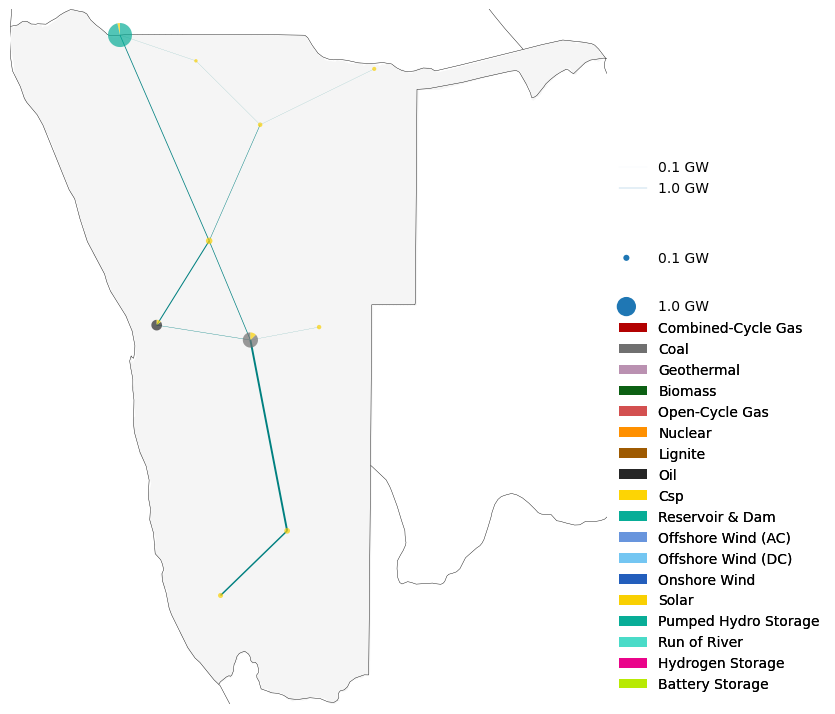

In [62]:
# Scale settings
bus_scale = 6e3 
line_scale = 6e3

# Legend settings
bus_sizes = [100, 1000]  # in MW
line_sizes = [100, 1000]  # in MW

n.carriers.drop("Load", inplace=True)
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={"projection": ccrs.EqualEarth(n.buses.x.mean())})
gen = n.generators[n.generators.carrier != "load"].groupby(["bus", "carrier"]).p_nom.sum()
sto = n.storage_units.groupby(["bus", "carrier"]).p_nom.sum()
buses = pd.concat([gen, sto])

with plt.rc_context({"patch.linewidth": 0.}):
    n.plot(
        bus_sizes=buses / bus_scale,
        bus_alpha=0.7,
        line_widths=n.lines.s_nom_opt / line_scale,
        link_widths=n.links.p_nom_opt / line_scale,
        line_colors="teal",
        ax=ax,
        margin=0.2,
        color_geomap=None,
    )
regions_onshore.plot(
    ax=ax,
    facecolor="whitesmoke",
    edgecolor="white",
    aspect="equal",
    transform=ccrs.PlateCarree(),
    linewidth=0,
)
ax.set_extent(regions_onshore.total_bounds[[0, 2, 1, 3]])
legend_kwargs = {"loc": "upper left", "frameon": False}
legend_circles_dict = {"bbox_to_anchor": (1, 0.67), "labelspacing": 2.5, **legend_kwargs}

add_legend_circles(
    ax,
    [s / bus_scale for s in bus_sizes],
    [f"{s / 1000} GW" for s in bus_sizes],
    legend_kw=legend_circles_dict,    
)
add_legend_lines(
    ax,
    [s / line_scale for s in line_sizes],
    [f"{s / 1000} GW" for s in line_sizes],
    legend_kw={"bbox_to_anchor": (1, 0.8), **legend_kwargs},
)
add_legend_patches(
    ax,
    n.carriers.color,
    n.carriers.nice_name,
    legend_kw={"bbox_to_anchor": (1, 0), **legend_kwargs, "loc":"lower left"},
)
fig.tight_layout()

Analyse the current generation capacity of the energy system - pie chart view

Text(0.5, 1.0, 'Generator Capacity by Carrier')

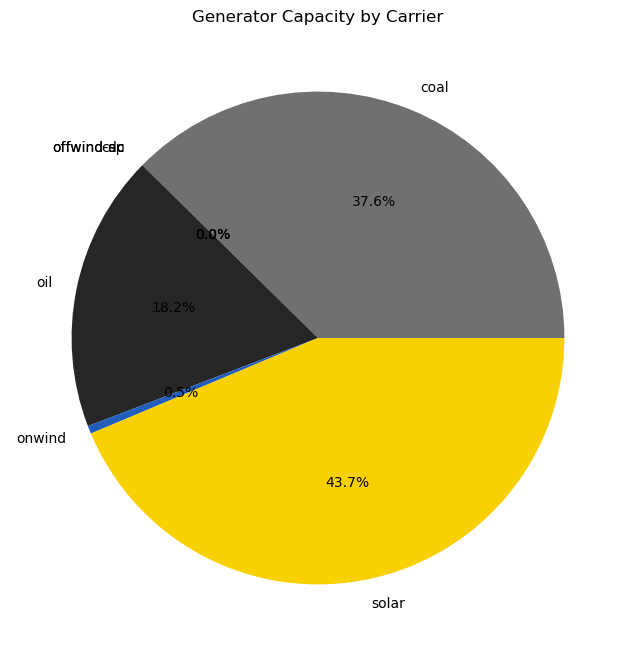

In [63]:
generator_capacity_by_carrier = (
    n.generators[n.generators.carrier != "load"]
    .groupby(["carrier"])
    .p_nom.sum()
)
plt.figure(figsize=(8, 8))
plt.pie(
    generator_capacity_by_carrier,
    labels=generator_capacity_by_carrier.index,
    autopct='%1.1f%%',
    colors=n.carriers[
            n.carriers.index.isin(generator_capacity_by_carrier.index)
        ].color.reindex(generator_capacity_by_carrier.index)
)
plt.title("Generator Capacity by Carrier")

Analyse the current gernation capacity of the energy system - tabular view

In [64]:
generator_capacity_by_carrier/1e3 # in GW

carrier
coal          0.120000
csp           0.000000
offwind-ac    0.000000
offwind-dc    0.000000
oil           0.058014
onwind        0.001661
solar         0.139230
Name: p_nom, dtype: float64

Analyse the future capacity of the energy system - map view

/home/mike/anaconda3/envs/pypsa-earth-new/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning:

facecolor will have no effect as it has been defined as "never".



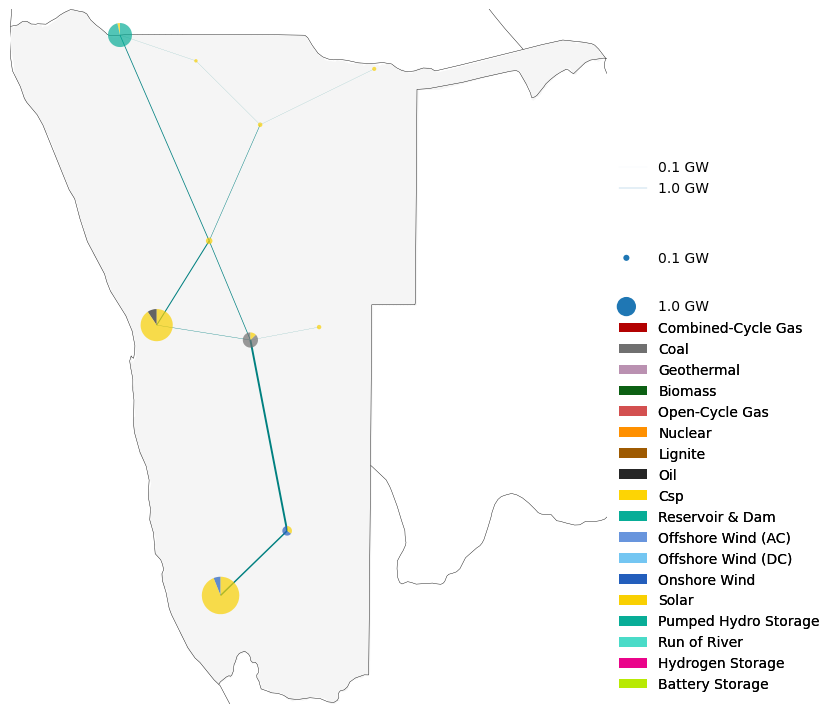

In [65]:
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={"projection": ccrs.EqualEarth(n.buses.x.mean())})
gen = n.generators[n.generators.carrier != "load"].groupby(["bus", "carrier"]).p_nom_opt.sum()
sto = n.storage_units.groupby(["bus", "carrier"]).p_nom_opt.sum()
buses = pd.concat([gen, sto])

with plt.rc_context({"patch.linewidth": 0.}):
    n.plot(
        bus_sizes=buses / bus_scale,
        bus_alpha=0.7,
        line_widths=n.lines.s_nom_opt / line_scale,
        link_widths=n.links.p_nom_opt / line_scale,
        line_colors="teal",
        ax=ax,
        margin=0.2,
        color_geomap=None,
    )
regions_onshore.plot(
    ax=ax,
    facecolor="whitesmoke",
    edgecolor="white",
    aspect="equal",
    transform=ccrs.PlateCarree(),
    linewidth=0,
)
ax.set_extent(regions_onshore.total_bounds[[0, 2, 1, 3]])
legend_kwargs = {"loc": "upper left", "frameon": False}
legend_circles_dict = {"bbox_to_anchor": (1, 0.67), "labelspacing": 2.5, **legend_kwargs}

add_legend_circles(
    ax,
    [s / bus_scale for s in bus_sizes],
    [f"{s / 1000} GW" for s in bus_sizes],
    legend_kw=legend_circles_dict,    
)
add_legend_lines(
    ax,
    [s / line_scale for s in line_sizes],
    [f"{s / 1000} GW" for s in line_sizes],
    legend_kw={"bbox_to_anchor": (1, 0.8), **legend_kwargs},
)
add_legend_patches(
    ax,
    n.carriers.color,
    n.carriers.nice_name,
    legend_kw={"bbox_to_anchor": (1, 0), **legend_kwargs, "loc":"lower left"},
)
fig.tight_layout()

Analys the future generation capacity expansion of the energy system - bar chart

<Axes: title={'center': 'Generator capacity expansion in GW'}, xlabel='carrier'>

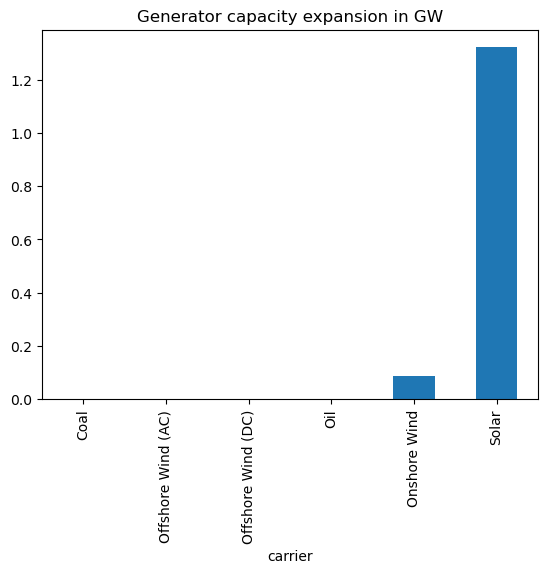

In [66]:
optimal_capacity = n.statistics.optimal_capacity(comps=["Generator"]).droplevel(0).div(1e3)
installed_capacity = n.statistics.installed_capacity(comps=["Generator"]).droplevel(0).div(1e3)
generation_capacity_expansion = optimal_capacity - installed_capacity
generation_capacity_expansion.drop(["load"], inplace=True)
generation_capacity_expansion.plot.bar(title="Generator capacity expansion in GW")

Plot the future generation capacity expansion of the energy system - tabular chart

In [67]:
generation_capacity_expansion # In GW

carrier
Coal                  0.000000
Offshore Wind (AC)         NaN
Offshore Wind (DC)         NaN
Oil                   0.000000
Onshore Wind          0.085893
Solar                 1.320954
dtype: float64

Analyse the future energy generation of the energy system - bar chart view

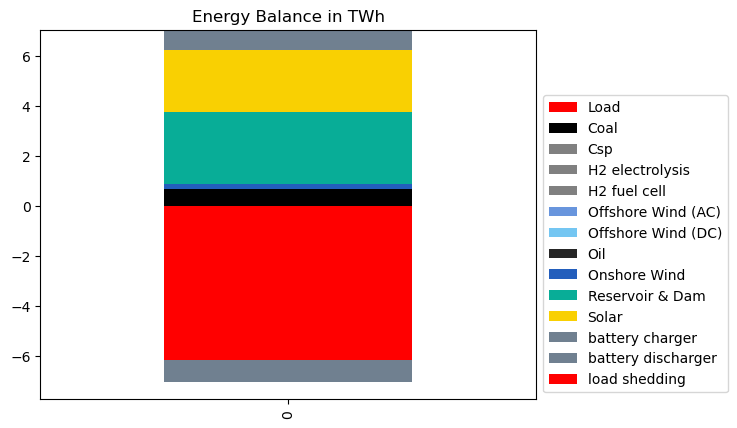

In [68]:
colors = {key.lower(): value.lower() for key, value in cfg["plotting"]["tech_colors"].items()}
nice_names = {value.lower(): key for key, value in cfg["plotting"]["nice_names"].items()}

rename_cols = {
    '-': 'Load',
    'load': 'load shedding',
}

energy_balance = (
    n.statistics.energy_balance()
    .loc[:, :, "AC"]
    .groupby("carrier")
    .sum()
    .div(1e6)
    .to_frame()
    .T
    .rename(columns=rename_cols)
)

# color-matching
color_list = []
for col in energy_balance.columns:
    original_name = col.lower()
    key_name = nice_names.get(original_name, original_name)
    color = colors.get(key_name.lower(), 'gray')
    color_list.append(color)


fig, ax = plt.subplots()
energy_balance.plot.bar(stacked=True, ax=ax, title="Energy Balance in TWh", color=color_list)
handles, labels = ax.get_legend_handles_labels()
nice_labels = [cfg["plotting"]["nice_names"].get(label, label) for label in energy_balance.columns]
ax.legend(handles, nice_labels, bbox_to_anchor=(1, 0), loc="lower left", title=None, ncol=1)

plt.show()

Analyse the future energy generation of the energy system - tabular view

In [69]:
n.statistics.energy_balance()/1e6 # In TWh

component    carrier             bus_carrier     
StorageUnit  Reservoir & Dam     AC                  2.908307e+00
Load         -                   AC                 -6.154579e+00
Link         Csp                 Csp                -5.000000e-11
             H2 electrolysis     AC                 -3.087900e-07
             H2 fuel cell        Hydrogen Storage   -2.100000e-07
             battery charger     AC                 -8.760322e-01
             battery discharger  Battery Storage    -8.409909e-01
             Csp                 AC                  5.000000e-11
             H2 electrolysis     Hydrogen Storage    2.099800e-07
             H2 fuel cell        AC                  1.050000e-07
             battery charger     Battery Storage     8.409909e-01
             battery discharger  AC                  8.073513e-01
Generator    Coal                AC                  6.588705e-01
             Offshore Wind (AC)  AC                  1.136900e-07
             Offshore Wind

## Analyse pv and wind potential - map view

In [70]:
solar = xr.open_dataset(solar_path)
wind = xr.open_dataset(onwind_path)

def plot_voronoi(n, carrier, voronoi, cmap, projection, title=None, filename=None):
    g = n.generators.loc[n.generators.carrier == carrier]
    br = gpd.read_file(f"{PARENT}resources/{scenario_name}/bus_regions/regions_{voronoi}.geojson").set_index("name")
    br_area = br.to_crs("ESRI:54009")
    br_area = br_area.geometry.area * 1e-6
    br["p_nom_max"] = g.groupby("bus").sum().p_nom_max / br_area

    fig, ax = plt.subplots(figsize=(8, 4), subplot_kw={"projection": projection})
    plt.rcParams.update({"font.size": 10})
    br.plot(
        ax=ax,
        column="p_nom_max",
        transform=ccrs.PlateCarree(),
        linewidth=0.25,
        edgecolor="k",
        cmap=cmap,
        vmin=0,
        vmax=br["p_nom_max"].max(),
        legend=True,
        legend_kwds={"label": r"potential density"},
    )
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS.with_scale("110m"))
    ax.set_extent(country_coordinates, crs=ccrs.PlateCarree()) 
    
    if title is not None:
        plt.title(title)

Plot wind energy potential

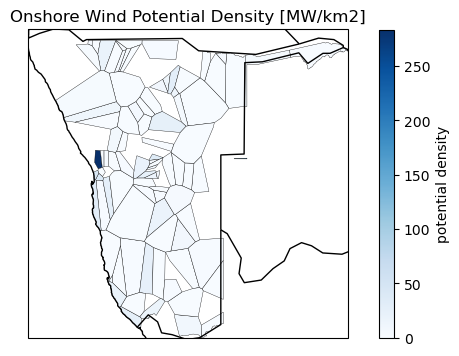

In [71]:
warnings.simplefilter(action='ignore', category=FutureWarning)
plot_voronoi(
    pypsa.Network(network_path),
    "onwind",
    "onshore",
    "Blues",
    ccrs.PlateCarree(),
    title="Onshore Wind Potential Density [MW/km2]",
)
warnings.simplefilter(action='default', category=FutureWarning)

Plot pv energy potential

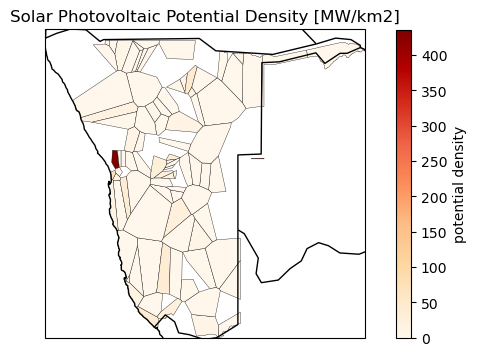

In [72]:
warnings.simplefilter(action='ignore', category=FutureWarning)
plot_voronoi(
    pypsa.Network(network_path),
    "solar",
    "onshore",
    "OrRd",
    ccrs.PlateCarree(),
    title="Solar Photovoltaic Potential Density [MW/km2]",
)
warnings.simplefilter(action='default', category=FutureWarning)